In [127]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1ibTdY7Px7KBDSY3s9A4q63tVq8FNJ6UB')

In [114]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from tqdm import tqdm_notebook 
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
import torch

In [26]:
jovian.commit(project = "heart-failure-prediction-using-ffn")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ml/girin-iitm/heart-failure-prediction-using-ffn


'https://jovian.ml/girin-iitm/heart-failure-prediction-using-ffn'

**Data**

In [58]:
df = pd.read_csv('/content/drive/My Drive/Dataset/heart rate/heart_failure_clinical_records_dataset.csv')
df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [59]:
data = df.drop(['DEATH_EVENT'], axis=1).to_numpy()
labels = df['DEATH_EVENT'].to_numpy()

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_test.shape, labels.shape)

(224, 12) (75, 12) (299,)


In [107]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

**Convert to tensors**

In [108]:
X_train, Y_train, X_test, Y_test = map(torch.tensor, (X_train, Y_train, X_test, Y_test))

In [109]:
print(X_train.shape, Y_train.shape)

torch.Size([224, 12]) torch.Size([224])


In [110]:
X_train = X_train.float()
Y_train = Y_train.float() 
X_test = X_test.float()
Y_test = Y_test.float()

In [89]:
import torch.nn.functional as F
import torch.nn as nn
from torch import optim

In [93]:
# Define the network and forward pass

class CNNetwork(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(12, 64), 
        nn.Sigmoid(), 
        nn.Linear(64,16),
        nn.Sigmoid(), 
        nn.Linear(16,1),
        nn.Sigmoid(),
    )

  def forward(self, X):
    xx = self.net(X)
    xx = torch.reshape(xx, (-1,))
    return xx

In [124]:
# define the fitting function
def fitt(x, y, model, opt, loss_fn, epochs = 800):
  loss_train_arr = []
  loss_test_arr = []
  acc_train_arr = []
  acc_test_arr = []
  for i in tqdm_notebook(range(epochs),total = epochs, unit = 'epoch'):
    loss_train = loss_fn(model(x), y) 
    loss_test = loss_fn(model(X_test), Y_test) 
    
    threshold = .7
    y_ht_train = (model(x)>=threshold).to(torch.float).numpy()
    y_ht_test  = (model(X_test)>=threshold).to(torch.float).numpy()
    accuracy_train = accuracy_score(y,y_ht_train)
    accuracy_test = accuracy_score(Y_test,y_ht_test)
    
    acc_train_arr.append(accuracy_train.item())
    acc_test_arr.append(accuracy_test.item())
    loss_train_arr.append(loss_train.item())
    loss_test_arr.append(loss_test.item())
    
    loss_train.backward()
    opt.step()
    opt.zero_grad()
    if i%100 == 0:
      print("Epoch : {} , Test_Loss : {:.3f}, Train_Loss : {:.3f}".format(i,loss_test,loss_train))
  #print("Predicted value : {} , True Value : {}".format(model(X_test),Y_test))
  
  threshold = .7
  y_ht_test  = (model(X_test)>=threshold).to(torch.float).numpy()
  print(classification_report(Y_test.detach().numpy() , y_ht_test))
  
  plt.figure(figsize=(10, 7))
  plt.subplot(121)
  plt.plot(loss_train_arr, 'r-',label = "Training Loss")
  plt.plot(loss_test_arr, 'b-', label = "Test Loss")
  plt.legend(["Training Loss", "Test loss"], loc ="best") 
  
  plt.subplot(122)
  plt.plot(acc_train_arr, 'r-',label = "Training Loss")
  plt.plot(acc_test_arr, 'b-', label = "Test Loss")
  plt.legend(["Training accuracy", "Test accuracy"], loc ="best") 
  
  plt.show()      
  print("Final Training Loss : {:.3f}, Final Test Loss : {:.3f}".format(loss_train_arr[-1],loss_test_arr[-1]))
  return

Epoch : 0 , Test_Loss : 0.629, Train_Loss : 0.630
Epoch : 100 , Test_Loss : 0.495, Train_Loss : 0.493
Epoch : 200 , Test_Loss : 0.367, Train_Loss : 0.387
Epoch : 300 , Test_Loss : 0.354, Train_Loss : 0.369
Epoch : 400 , Test_Loss : 0.353, Train_Loss : 0.344
Epoch : 500 , Test_Loss : 0.358, Train_Loss : 0.295
Epoch : 600 , Test_Loss : 0.390, Train_Loss : 0.224
Epoch : 700 , Test_Loss : 0.455, Train_Loss : 0.147

              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89        51
         1.0       0.83      0.62      0.71        24

    accuracy                           0.84        75
   macro avg       0.84      0.78      0.80        75
weighted avg       0.84      0.84      0.83        75



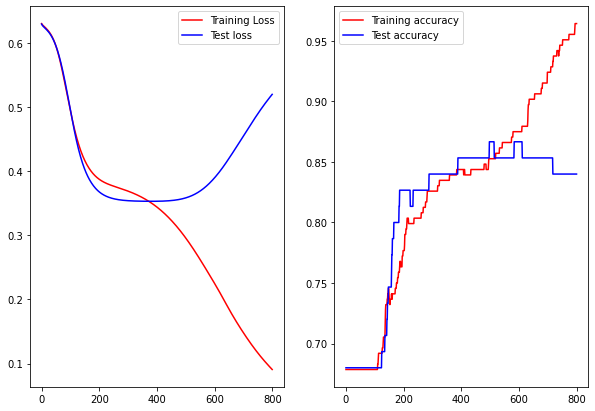

Final Training Loss : 0.091, Final Test Loss : 0.519


In [125]:
# Run
fn = CNNetwork()
loss_fn = F.binary_cross_entropy
#opt = optim.SGD(fn.parameters(), lr=.8)
opt = optim.Adam(fn.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
fitt(X_train, Y_train, fn, opt, loss_fn)

In [128]:
jovian.commit(project = "heartfailure-prediction-using-ffn")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ml/girin-iitm/heartfailure-prediction-using-ffn


'https://jovian.ml/girin-iitm/heartfailure-prediction-using-ffn'